In [1]:
import cell2cell as c2c
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlp

from cci_distance_correlation import get_correlation

from tqdm import tqdm
from sklearn.utils import shuffle

import json

%matplotlib inline

# Analysis Setup

Here, all inputs and parameters needed for the analysis are defined

**Location of files**

In [2]:
data_folder = '../data/'

In [ ]:
import os

output_folder = '../results/GA-Permutation/'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [3]:
files = dict()
files['rnaseq'] = data_folder + '/RNA-Seq/Celegans_RNASeqData_Cell.xlsx'
files['metadata'] = data_folder + '/RNA-Seq/Celegans_cell_metadata.tsv'
files['ppi'] = data_folder + '/PPI-Networks/Celegans-Curated-LR-pairs.xlsx'
files['output_folder'] = output_folder

**RNA-seq data manipulation**

- <font color="green">'gene_col'</font> is the name of the column containing the list or names of genes in the dataset.
- <font color="green">'drop_nangenes'</font> is a boolean decision to remove genes with NaN values.
- <font color="green">'log_transform'</font> is a boolean decision to log-transform the dataset.

In [4]:
rnaseq_setup = dict()
rnaseq_setup['gene_col'] = 'gene_id'
rnaseq_setup['drop_nangenes'] = True
rnaseq_setup['log_transform'] = False

**Metadata columns**

- <font color="green">'sample_col'</font> is the name of the column containing the sample or cell names in RNA-seq data (equivalent to the columns in rnaseq_data).
- <font color="green">'group_col'</font> is the name of the column containing the labels for the respective samples or cells in order to group/color them in downstream analyses.

In [5]:
meta_setup = dict()
meta_setup['sample_col'] = '#SampleID'
meta_setup['group_col'] = 'Groups'

**Columns for PPI network**

- <font color="green">'protein_cols'</font> is a list containing the names of the first and second interactors.

In [6]:
ppi_setup = dict()
ppi_setup['protein_cols'] = ['Ligand_WB', 'Receptor_WB']

**Cutoffs setup for binarizing gene expression**

- <font color="green">'type'</font> is the type of cutoff to use. 
    - 'constant_value'
    - 'local_percentile'
    - 'global_percentile'
    - None
- <font color="green">'parameter'</font> is the corresponding parameter for the type of cutoff. If percentile is used, it should be a value between 0 and 1. E.g. a value of 0.75 represents the 75-th percentile, and the cutoff to binarize the gene expression will be that value.

In [7]:
cutoff_setup = dict()
cutoff_setup['type'] = 'constant_value'
cutoff_setup['parameter'] = 10 # TPM

**General Analysis setups**

- <font color="green">'communication_score'</font> is the type of communication score used to detect active pathways between each pair of cell. It can be:
    - 'expression_thresholding'
    - 'expression_product'
    - 'expression_correlation'
    - 'differential_combinations'
- <font color="green">'cci_score'</font> is the scoring function to aggregate the communication scores. It can be:
    - 'bray_curtis'
    - 'jaccard'
    - 'count'
- <font color="green">'cci_type'</font> is the type of interaction between two cells. If it is undirected, ligand and receptor are considered from both cells. If it is directed, ligands from one cell and receptors from the other are considered separately with respect to ligands from the second cell and receptor from the first one. So, it can be:
    - 'undirected'
    - 'directed

In [8]:
analysis_setup = dict()
analysis_setup['communication_score'] = 'expression_thresholding'
analysis_setup['cci_score'] = 'bray_curtis'
analysis_setup['cci_type'] = 'undirected'

# Load Data

**RNA-seq**

In [9]:
rnaseq_data = c2c.io.load_rnaseq(rnaseq_file=files['rnaseq'],
                                 gene_column=rnaseq_setup['gene_col'],
                                 drop_nangenes=rnaseq_setup['drop_nangenes'],
                                 log_transformation=rnaseq_setup['log_transform'],
                                 format='auto')

Opening RNAseq datasets from ../Data//RNA-Seq/Celegans_RNASeqData_Cell.xlsx
../Data//RNA-Seq/Celegans_RNASeqData_Cell.xlsx was correctly loaded


**Metadata for cell types**

In [10]:
meta = c2c.io.load_metadata(metadata_file=files['metadata'],
                            cell_labels=rnaseq_data.columns,
                            format='auto')

../Data//RNA-Seq/Celegans_cell_metadata.tsv was correctly loaded


**PPI network**

In [11]:
original_ppi_data = c2c.io.load_ppi(ppi_file=files['ppi'],
                                    interaction_columns=ppi_setup['protein_cols'],
                                    rnaseq_genes=list(rnaseq_data.index),
                                    format='auto')

Opening PPI datasets from ../Data//PPI-Networks/Celegans-Curated-LR-pairs.xlsx
../Data//PPI-Networks/Celegans-Curated-LR-pairs.xlsx was correctly loaded
Removing bidirectionality of PPI network
Simplying PPI network


In [12]:
print('PPI data has {} PPIs'.format(len(original_ppi_data)))
print('Number of Ligands: {}'.format(original_ppi_data.A.unique().shape[0]))
print('Number of Receptors: {}'.format(original_ppi_data.B.unique().shape[0]))

PPI data has 245 PPIs
Number of Ligands: 127
Number of Receptors: 66


In [13]:
ppi_data = c2c.io.load_ppi(data_folder + '/PPI-Networks/Celegans-GA-BrayCurtis-Selected-LR-pairs.csv',
                           interaction_columns=ppi_setup['protein_cols'],
                           rnaseq_genes=list(rnaseq_data.index),
                           format='auto')
ppi_data = ppi_data.drop_duplicates()
ppi_data.reset_index(inplace=True, drop=True)

Opening PPI datasets from ../Data//PPI-Networks/Celegans-GA-Selected-LR-pairs.csv
../Data//PPI-Networks/Celegans-GA-Selected-LR-pairs.csv was correctly loaded
Removing bidirectionality of PPI network
Simplying PPI network


In [14]:
print('PPI data has {} PPIs'.format(len(ppi_data)))
print('Number of Ligands: {}'.format(ppi_data.A.unique().shape[0]))
print('Number of Receptors: {}'.format(ppi_data.B.unique().shape[0]))

PPI data has 37 PPIs
Number of Ligands: 30
Number of Receptors: 29


**Phenotype**

In [15]:
physical_distance = c2c.io.load_table(data_folder + '/Digital-3D-Map/Celegans_Physical_Distances_Min.csv',
                                          **{'index_col' : 0})

../Data//Digital-3D-Map/Celegans_Physical_Distances_Min.csv was correctly loaded


# Run Analysis

**Cells to include**

In [16]:
manually_excluded = [
                     #'Germline'
                    ]
included_cells = sorted(list((set(rnaseq_data.columns) & set(physical_distance.columns) - set(manually_excluded))))

## Permutation of Ligands or Receptors (independently)

In [17]:
corr_dist = {'permutation' : dict(),
             'label_switching' : dict() 
            } # A: Ligand; B: Receptor

In [18]:
permu_number = 9999

**Permutate Ligands**

In [19]:
shuffle_col = 'A'
corr_dist['permutation'][shuffle_col] = []

for i in tqdm(range(permu_number)):
    shuffled_ppi_data = c2c.preprocessing.shuffle_cols_in_df(ppi_data, shuffle_col, random_state=i)
    bi_ppi_data = c2c.preprocessing.bidirectional_ppi_for_cci(ppi_data=shuffled_ppi_data, verbose=False)
    interaction_space = c2c.core.InteractionSpace(rnaseq_data=rnaseq_data[included_cells],
                                                  ppi_data=bi_ppi_data,
                                                  gene_cutoffs=cutoff_setup,
                                                  communication_score=analysis_setup['communication_score'],
                                                  cci_score=analysis_setup['cci_score'],
                                                  cci_type=analysis_setup['cci_type'],
                                                  verbose=False)
    
    interaction_space.compute_pairwise_cci_scores(verbose=False)
    
    corr_dist['permutation'][shuffle_col].append(get_correlation(physical_distance.loc[included_cells, included_cells],
                                                                 interaction_space.interaction_elements['cci_matrix'].loc[included_cells, included_cells],
                                                                 corr_type = 'spearman'
                                                                 )
                                                 )

100%|███████████████████████████████████████████████████████████████████████████| 9999/9999 [16:58<00:00,  9.82it/s]


**Permutate Receptors**

In [20]:
shuffle_col = 'B'
corr_dist['permutation'][shuffle_col] = []

for i in tqdm(range(permu_number)):
    shuffled_ppi_data = c2c.preprocessing.shuffle_cols_in_df(ppi_data, shuffle_col, random_state=i)
    bi_ppi_data = c2c.preprocessing.bidirectional_ppi_for_cci(ppi_data=shuffled_ppi_data, verbose=False)
    interaction_space = c2c.core.InteractionSpace(rnaseq_data=rnaseq_data[included_cells],
                                                  ppi_data=bi_ppi_data,
                                                  gene_cutoffs=cutoff_setup,
                                                  communication_score=analysis_setup['communication_score'],
                                                  cci_score=analysis_setup['cci_score'],
                                                  cci_type=analysis_setup['cci_type'],
                                                  verbose=False)
    
    interaction_space.compute_pairwise_cci_scores(verbose=False)
    
    corr_dist['permutation'][shuffle_col].append(get_correlation(physical_distance.loc[included_cells, included_cells],
                                                                 interaction_space.interaction_elements['cci_matrix'].loc[included_cells, included_cells],
                                                                 corr_type = 'spearman'
                                                                 )
                                                 )

100%|███████████████████████████████████████████████████████████████████████████| 9999/9999 [16:49<00:00,  9.90it/s]


## Switch labels of proteins (ligands or receptors, independently)

**Switch Ligand Labels**

In [21]:
shuffle_col = 'A'
corr_dist['label_switching'][shuffle_col] = []

for i in tqdm(range(permu_number)):
    shuffled_ppi_data = c2c.stats.random_switching_ppi_labels(ppi_data, permuted_column='first', random_state=i)
    bi_ppi_data = c2c.preprocessing.bidirectional_ppi_for_cci(ppi_data=shuffled_ppi_data, verbose=False)
    interaction_space = c2c.core.InteractionSpace(rnaseq_data=rnaseq_data[included_cells],
                                                  ppi_data=bi_ppi_data,
                                                  gene_cutoffs=cutoff_setup,
                                                  communication_score=analysis_setup['communication_score'],
                                                  cci_score=analysis_setup['cci_score'],
                                                  cci_type=analysis_setup['cci_type'],
                                                  verbose=False)
    
    interaction_space.compute_pairwise_cci_scores(verbose=False)
    
    corr_dist['label_switching'][shuffle_col].append(get_correlation(physical_distance.loc[included_cells, included_cells],
                                                                     interaction_space.interaction_elements['cci_matrix'].loc[included_cells, included_cells],
                                                                     corr_type = 'spearman'
                                                                     )
                                                     )

100%|███████████████████████████████████████████████████████████████████████████| 9999/9999 [16:47<00:00,  9.92it/s]


**Switch Receptor Labels**

In [22]:
shuffle_col = 'B'
corr_dist['label_switching'][shuffle_col] = []

for i in tqdm(range(permu_number)):
    shuffled_ppi_data = c2c.stats.random_switching_ppi_labels(ppi_data, permuted_column='second', random_state=i)
    bi_ppi_data = c2c.preprocessing.bidirectional_ppi_for_cci(ppi_data=shuffled_ppi_data, verbose=False)
    interaction_space = c2c.core.InteractionSpace(rnaseq_data=rnaseq_data[included_cells],
                                                  ppi_data=bi_ppi_data,
                                                  gene_cutoffs=cutoff_setup,
                                                  communication_score=analysis_setup['communication_score'],
                                                  cci_score=analysis_setup['cci_score'],
                                                  cci_type=analysis_setup['cci_type'],
                                                  verbose=False)
    
    interaction_space.compute_pairwise_cci_scores(verbose=False)
    
    corr_dist['label_switching'][shuffle_col].append(get_correlation(physical_distance.loc[included_cells, included_cells],
                                                                     interaction_space.interaction_elements['cci_matrix'].loc[included_cells, included_cells],
                                                                     corr_type = 'spearman'
                                                                     )
                                                     )

100%|███████████████████████████████████████████████████████████████████████████| 9999/9999 [16:50<00:00,  9.90it/s]


## Subsample original PPI network

In [23]:
corr_dist['subsampling'] = []

for i in tqdm(range(permu_number)):
    subsampled_ppi_data = c2c.preprocessing.subsample_dataframe(df=original_ppi_data, n_samples=ppi_data.shape[0], random_state=i).reset_index(drop=True)
    subsampled_ppi_data = subsampled_ppi_data.assign(score=1.0)
    bi_ppi_data = c2c.preprocessing.bidirectional_ppi_for_cci(ppi_data=subsampled_ppi_data, verbose=False)
    interaction_space = c2c.core.InteractionSpace(rnaseq_data=rnaseq_data[included_cells],
                                                  ppi_data=bi_ppi_data,
                                                  gene_cutoffs=cutoff_setup,
                                                  communication_score=analysis_setup['communication_score'],
                                                  cci_score=analysis_setup['cci_score'],
                                                  cci_type=analysis_setup['cci_type'],
                                                  verbose=False)
    
    interaction_space.compute_pairwise_cci_scores(verbose=False)
    
    corr_dist['subsampling'].append(get_correlation(physical_distance.loc[included_cells, included_cells],
                                                    interaction_space.interaction_elements['cci_matrix'].loc[included_cells, included_cells],
                                                    corr_type = 'spearman'
                                                    )
                                                 )

100%|███████████████████████████████████████████████████████████████████████████| 9999/9999 [16:46<00:00,  9.93it/s]


## Compute p-values

**Correlation with GA-Selected LR list**

In [24]:
if analysis_setup['cci_type'] == 'undirected':
    bi_ppi_data = c2c.preprocessing.bidirectional_ppi_for_cci(ppi_data=ppi_data, verbose=False)
    ref_ppi = ppi_data
else:
    bi_ppi_data = ppi_data.copy()
    ref_ppi = None

interaction_space = c2c.core.InteractionSpace(rnaseq_data=rnaseq_data[included_cells],
                                              ppi_data=bi_ppi_data,
                                              gene_cutoffs=cutoff_setup,
                                              communication_score=analysis_setup['communication_score'],
                                              cci_score=analysis_setup['cci_score'],
                                              cci_type=analysis_setup['cci_type'],
                                              verbose=False)

interaction_space.compute_pairwise_cci_scores(verbose=False)

In [25]:
# Correlation
corr_value = get_correlation(physical_distance.loc[included_cells, included_cells],
                             interaction_space.interaction_elements['cci_matrix'].loc[included_cells, included_cells],
                             corr_type = 'spearman'
                             )

corr_value

SpearmanrResult(correlation=-0.6333657309057459, pvalue=2.6294765000591562e-27)

Add analysis value to the random distributions

In [26]:
corr_dist['permutation']['A'].append(corr_value)
corr_dist['permutation']['B'].append(corr_value)
corr_dist['label_switching']['A'].append(corr_value)
corr_dist['label_switching']['B'].append(corr_value)
corr_dist['subsampling'].append(corr_value)

**Permutation of columns (ligands/receptor)**

/home/earmingol/anaconda3/envs/cell2cell/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


P-value is: 0.0002
P-value is: 0.0002


/home/earmingol/anaconda3/envs/cell2cell/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


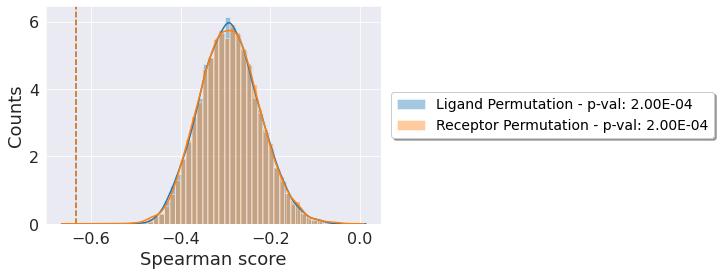

In [27]:
fig_l, pval_l = c2c.stats.pvalue_from_dist(corr_value[0],
                                           [corr[0] for corr in corr_dist['permutation']['A']],
                                           label='Ligand Permutation',
                                           comparison='different'
                                          )

fig_r, pval_r = c2c.stats.pvalue_from_dist(corr_value[0],
                                           [corr[0] for corr in corr_dist['permutation']['B']],
                                           label='Receptor Permutation',
                                           comparison='different'
                                          )
    
plt.xlabel('Spearman score', fontsize=18)
plt.ylabel('Counts', fontsize=18)

plt.savefig(output_folder + '/Pval-Permutation-LR.svg',
                dpi=300,
                bbox_inches='tight')

**Shuffling Protein names**

P-value is: 0.0002
P-value is: 0.0002


/home/earmingol/anaconda3/envs/cell2cell/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/earmingol/anaconda3/envs/cell2cell/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


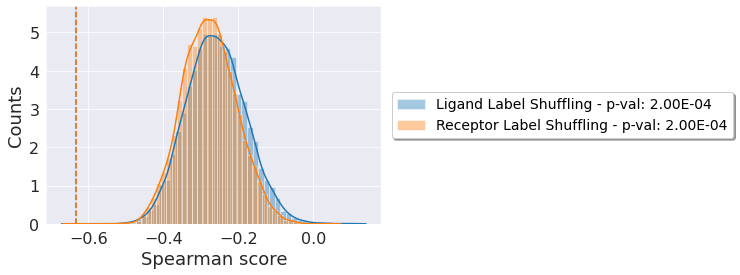

In [28]:
fig_l, pval_l = c2c.stats.pvalue_from_dist(corr_value[0],
                                           [corr[0] for corr in corr_dist['label_switching']['A']],
                                           label='Ligand Label Shuffling',
                                           comparison='different'
                                          )

fig_r, pval_r = c2c.stats.pvalue_from_dist(corr_value[0],
                                           [corr[0] for corr in corr_dist['label_switching']['B']],
                                           label='Receptor Label Shuffling',
                                           comparison='different'
                                          )
    
plt.xlabel('Spearman score', fontsize=18)
plt.ylabel('Counts', fontsize=18)

plt.savefig(output_folder + '/Pval-Label-Shuffling-LR.svg',
                dpi=300,
                bbox_inches='tight')

**PPI Network Subsampling**

P-value is: 0.0002


/home/earmingol/anaconda3/envs/cell2cell/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


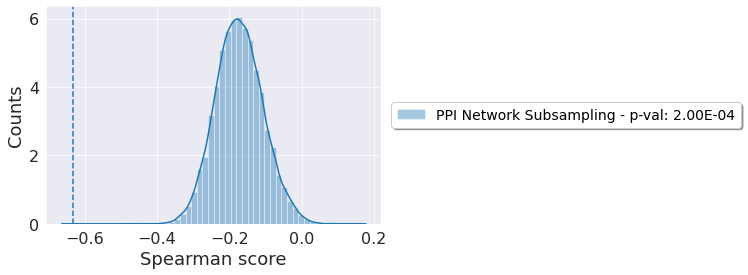

In [29]:
fig_, pval = c2c.stats.pvalue_from_dist(corr_value[0],
                                        [corr[0] for corr in corr_dist['subsampling']],
                                        label='PPI Network Subsampling',
                                        comparison='different'
                                       )
    
plt.xlabel('Spearman score', fontsize=18)
plt.ylabel('Counts', fontsize=18)

plt.savefig(output_folder + '/Pval-PPI-Subsampling.svg',
                dpi=300,
                bbox_inches='tight')

# Export results into JSON File

In [30]:
with open(output_folder + '/Permutation-Analysis.json', 'w') as outfile:
    json.dump(corr_dist, outfile)